<br>

# Movie recommender system : collaborative-content filtering

<br>

Hi everyone! Welcome to this Jupyter notebook on building a movie recommendation system! 

In today's world of seemingly endless movie choices, it can be difficult to decide what to watch next. This is where recommendation systems come in. By analyzing patterns in movie ratings, these systems can suggest movies that a user is likely to enjoy. In this notebook, we will explore the key concepts involved in building such a system. 

First we start with collaborative filtering and an hybrid nearest neighbors - matrix factorization approach. Collaborative filtering based on nearest neighbors allows us to identify similar users and recommend movies based on their past preferences. By comparing the movie ratings of different users, we can identify patterns and similarities, and use these to make recommendations for movies that a user hasn't yet seen. However, this approach has limitations like when there are sparse data. In these cases, matrix factorization can be used to fill in missing ratings in the matrix and make better predictions. 
By combining collaborative filtering and matrix factorization, we can create a more robust and effective movie recommendation system that leverages the strengths of both techniques.

Finally, we'll introduce content-based filtering, which is used to address some of the limitations of collaborative filtering. We'll discuss each of these concepts in detail and demonstrate how they can be combined to create a personalized and effective movie recommendation system.

##### The (super) team that built the system is composed of the following (super) members:
* Michèle Dubuisson
* Thomas Sabatier
* Antoine Sibille

##### The datasets files were taken from the following sources:
* Movie Lens (small) dataset : https://grouplens.org/datasets/movielens/
* IMDb dataset : https://www.imdb.com/interfaces/

<br>

### Librairies


In [1]:

# Regular librairies
import numpy as np
import pandas as pd
import random
import statistics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Machine learning
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split


## Collaborative filtering


### 1. Pre-processing

In [2]:

# Load datasets into a DataFrame
df_ml_movies = pd.read_csv('../data/ml-latest-small/movies.csv')
df_ml_ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
df_ml_links = pd.read_csv('../data/ml-latest-small/links.csv')
display(df_ml_links)

# Split movie title and movie release year
df_ml_movies['year'] = df_ml_movies['title'].str.extract('(\d{4})', expand=False)
df_ml_movies['title'] = df_ml_movies['title'].str.replace('(\(\d{4}\))', '', regex=True).str.strip()

# Select the usefull features
df_ml_movies = df_ml_movies[['movieId', 'title', 'year', 'genres']]
df_ml_ratings = df_ml_ratings.merge(df_ml_movies, how='inner', on='movieId')
df_ml_ratings = df_ml_ratings[['userId', 'movieId', 'rating', 'title']]

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


### 2. Data exploration

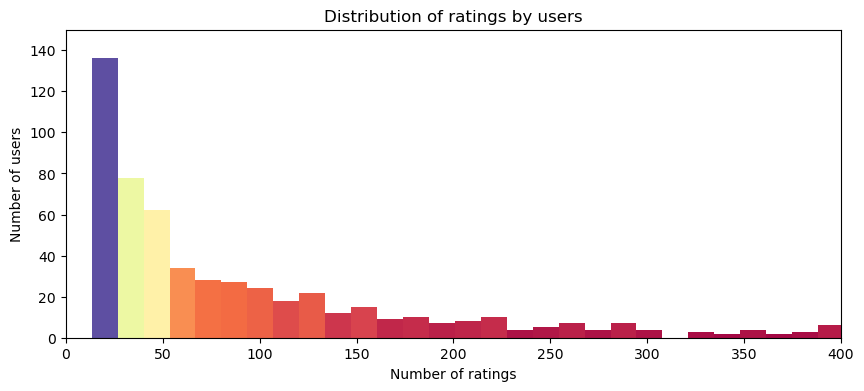

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: userId, dtype: float64


In [3]:

# Distribution of ratings by users
nb_ratings_by_user = df_ml_ratings['userId'].value_counts()

counts, bins = np.histogram(nb_ratings_by_user, bins=200) # Compute the histogram
cmap = plt.cm.Spectral
norm = plt.Normalize(counts.min(), counts.max()) # Normalize bar height

f,ax = plt.subplots(1,1,figsize=(10,4))
for count, x in zip(counts, bins[:-1]):
    plt.bar(x, count, width=bins[1]-bins[0], color=cmap(norm(count)))
plt.xlim(0, 400)
plt.ylim(0, 150)
plt.title('Distribution of ratings by users')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

print(nb_ratings_by_user.describe())

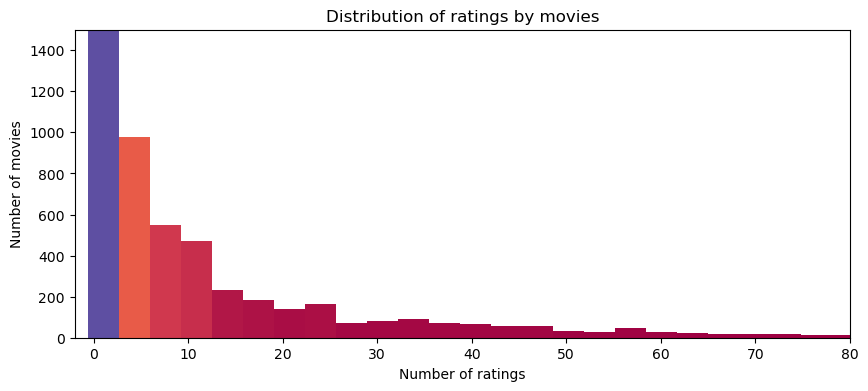

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: movieId, dtype: float64


In [4]:

# Distribution of ratings by movies
nb_ratings_by_movie = df_ml_ratings['movieId'].value_counts()

counts, bins = np.histogram(nb_ratings_by_movie, bins=100) # Compute the histogram
cmap = plt.cm.Spectral
norm = plt.Normalize(counts.min(), counts.max()) # Normalize bar height

f,ax = plt.subplots(1,1,figsize=(10,4))
for count, x in zip(counts, bins[:-1]):
    plt.bar(x, count, width=bins[1]-bins[0], color=cmap(norm(count)))
plt.xlim(-2, 80)
plt.ylim(0, 1500)
plt.title('Distribution of ratings by movies')
plt.xlabel('Number of ratings')
plt.ylabel('Number of movies')
plt.show()

print(nb_ratings_by_movie.describe())

### 3. Model building

#### Enter the matrix

In [5]:

# Convert the count Series into a DataFrame and filter the rows
df_nb_ratings_by_user = nb_ratings_by_user.to_frame(name='nb_of_ratings')
df_nb_ratings_by_user = df_nb_ratings_by_user.query('nb_of_ratings >= 35 and nb_of_ratings <= 170')
# Apply to the original matrix 
df_ml_ratings_filtered = df_ml_ratings[df_ml_ratings['userId'].isin(df_nb_ratings_by_user.index)]

# Convert the count Series into a DataFrame and filter the rows
df_nb_ratings_by_movie = nb_ratings_by_movie.to_frame(name='nb_of_ratings')
df_nb_ratings_by_movie = df_nb_ratings_by_movie.query('nb_of_ratings >=3')
# Apply to the original matrix 
df_ml_ratings_filtered = df_ml_ratings_filtered[df_ml_ratings_filtered['movieId'].isin(df_nb_ratings_by_movie.index)]

#matrix = df_ml_ratings_filtered.pivot_table(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
matrix = df_ml_ratings.pivot_table(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
matrix.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Méthode 1 : Matrix Factorization (Truncated SVD)

In [6]:

def matrix_factorization(matrix, n_components):
    
    sparse_matrix = csr_matrix(matrix)

   
    svd = TruncatedSVD(n_components=n_components)
    U_Sigma = svd.fit_transform(sparse_matrix)

 
    predicted_data = U_Sigma.dot(svd.components_)
    predicted_data = np.clip(predicted_data, 0.5, 5)  
    
   
    predicted_data = pd.DataFrame(predicted_data, index=matrix.index, columns=matrix.columns)

    return predicted_data


In [7]:

def what_do_we_watch_tonight(user_id, matrix, n_neighbors, latent_dimension, n_movies=10, enable_neighbors=True):
    
    if enable_neighbors == True:
    # Create a matrix based on the user nearest neighbors
        matrix_knn = nearest_neighbors_matrix(user_id=user_id, matrix=matrix, n_neighbors=n_neighbors)
    else:
        matrix_knn = matrix
        
    # Matrix factorization
    df_predictions = matrix_factorization(matrix_knn, latent_dimension)

    # Sort the predictions for the user by rating descending order
    sorted_user_predictions = df_predictions.loc[user_id].sort_values(ascending=False).to_frame(name="prediction")

    # Get the original rating of the user
    user_data = matrix_knn.loc[user_id].to_frame(name="rating")

    # Merge true ratings and predicted ratings
    user_full = pd.merge(left = user_data, right = sorted_user_predictions, how='inner', on='movieId')
    user_full = pd.merge(left = user_full, right = df_ml_movies, how='inner', on='movieId')

    # Filter on movies that the user hasn't rated yet
    user_full = user_full.loc[user_full['rating'] == 0]

    # Recommendations
    recommendations = user_full.sort_values(by='prediction', ascending=False).head(n_movies)
    recommendations = recommendations[['title', 'year', 'prediction']]
    recommendations = recommendations.reset_index(drop=True)
    
    return recommendations


#### Méthode 2 : Matrix Factorization (Surprise SVD)

In [8]:

# Convert data into Surprise Dataset
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_ml_ratings[['userId','movieId','rating']], reader)


In [9]:

# Hyper-parameters tuning with cross-validation
param_grid = {'n_factors': [50, 100, 150],
              'n_epochs': [10, 20, 30], 
              'lr_all': [0.002, 0.005, 0.01],
              'reg_all':[0.05, 0.1, 0.2]}

gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5)

gs.fit(data)


In [10]:

# Tuned SVD with best params from GridSearchCV
best_params = gs.best_params["rmse"]

algo = SVD(n_epochs=best_params['n_epochs'], 
           lr_all=best_params['lr_all'], 
           reg_all=best_params['reg_all'], 
           n_factors=best_params['n_factors'])

# Create and fit a trainset out of the full data dataset
trainset = data.build_full_trainset()
algo.fit(trainset)

best_params # Display best parameters


{'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}

In [16]:
# Define the SVD model with the best hyperparameters found during grid search
from surprise.model_selection import cross_validate
best_params = gs.best_params['rmse']
algo = SVD(n_epochs=best_params['n_epochs'], 
           lr_all=best_params['lr_all'], 
           reg_all=best_params['reg_all'], 
           n_factors=best_params['n_factors'])

# Perform cross-validation
cv_results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

# Calculate the average RMSE score across all folds
avg_rmse = sum(cv_results['test_rmse']) / len(cv_results['test_rmse'])

print('Average RMSE score:', avg_rmse)

Average RMSE score: 0.861283369504009


In [ ]:

def hey_honey_what_do_we_watch_tonight(user_id, top_n, trainset, algo): 
    
    # List of movies rated by a specific user
    rated_items = set(item_id for (item_id, _) in trainset.ur[random_user])
    
    # List of movies not rated yet by a specific user
    not_watched_yet = [item_id for item_id in trainset.all_items() if item_id not in rated_items]

    movie_titles = dict(zip(df_ml_ratings['movieId'], df_ml_ratings['title']))
    
    rated_movies = [(item_id, rating) for (item_id, rating) in trainset.ur[user_id]]
    sorted_rated_movies = sorted(rated_movies, key=lambda x: x[1], reverse=True)
    
     # Create rated movies string
    rated_movies_str = f"Top {top_n} des films déjà notés par l'utilisateur {user_id}:\n"
    rated_movies_str += "---------------------------------------\n"
    for item_id, rating in sorted_rated_movies[:top_n]:
        movie_id = trainset.to_raw_iid(item_id)  # Convert internal item_id to external movie_id
        rated_movies_str += f"{movie_id} | {movie_titles[movie_id]} | rating: {rating:.2f}\n"
    
    # Predictions
    predictions = [algo.predict(random_user, item_id) for item_id in not_watched_yet]
    sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)

    # Display top n recommendations
    recommendations_str = ""
    recommendations_str = f"Top {top_n} recommandations pour l'utilisateur {user_id}:\n"
    recommendations_str += "---------------------------------------\n"
    for pred in sorted_predictions[:top_n]:
        recommendations_str += f"{pred.iid} | {movie_titles[pred.iid]} | rating: {pred.est:.2f}\n"

    return recommendations_str, rated_movies_str


In [ ]:

# Randomly choose an user
user_ids = trainset.all_users()
random_user = random.choice(user_ids)

# Make top n recommendations and compare with the top n movies the user has rated
reco, rated = hey_honey_what_do_we_watch_tonight(random_user, 10, trainset, algo)
print(reco)
print(rated)

# Let's compare with predictions of the first method
#display(what_do_we_watch_tonight(random_user, matrix, n_neighbors=0, latent_dimension=100, n_movies=10, enable_neighbors=False))


## Content based-filtering

### Pre-processing

In [192]:

# file data loads IMDB and ML combined
df_movies = pd.read_csv('../data/IMDb/df_movies.csv')

# taking care of NaN and data types
df_movies['year']=df_movies['year'].fillna(df_movies['startYear'].astype('int'))
df_movies['year']=df_movies['year'].astype('int')
df_movies['title_year']=df_movies['title_ml']+' ('+df_movies['year'].astype('str')+')'
df_movies = df_movies[['movieId', 'title_ml','year','genres_ml', 'title_year',
                       'averageRating','numVotes','genres_imdb','tconst']]

In [193]:

# file data load ML tags
df_ml_genome_scores = pd.read_csv('../data/ml-20m/genome-scores.csv.gz')
df_ml_genome_tags = pd.read_csv('../data/ml-20m/genome-tags.csv')
df_ml_genome = df_ml_genome_scores.merge(df_ml_genome_tags, how='inner', on='tagId')

In [200]:

# Defining a threshold to retain ML tags relevance
threshold = 0.8
df_relevant = df_ml_genome[df_ml_genome['relevance'] > threshold]

# Transpose retained ML tags into one line per movie
df_grouped_by_tags = pd.DataFrame(df_relevant.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
df_ml_relevant_tags=pd.merge(df_movies,df_grouped_by_tags, on='movieId', how='left')

# Taking care of NaN and 'no genre'
df_ml_relevant_tags['tag']=df_ml_relevant_tags['tag'].fillna('')
df_ml_relevant_tags['genres_imdb']=df_ml_relevant_tags['genres_imdb'].fillna('')
df_ml_relevant_tags['genres_ml']=df_ml_relevant_tags['genres_ml'].replace(to_replace = '(no genres listed)', value = '')

# Joining tags and genres
df_ml_relevant_tags['tag']=df_ml_relevant_tags['genres_ml'].str.replace('|', ' ', regex=False)+' '+df_ml_relevant_tags['tag']+' '+df_ml_relevant_tags['genres_imdb'].str.replace(',', ' ')
df_ml_relevant_tags['tag']=df_ml_relevant_tags['tag'].str.lower()


In [203]:

# Creating word vector (for up to 3 words) and similar matrix
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), stop_words='english')
tfidf_tag_matrix = vectorizer.fit_transform(df_ml_relevant_tags['tag'])
similar_movie = cosine_similarity(tfidf_tag_matrix, tfidf_tag_matrix)


In [204]:

# Keeping movies indices
indices = pd.Series(df_ml_relevant_tags.index, index=df_ml_relevant_tags['title_year'])

# Building Content recommendation function
def content_recommendations(title, year, sim_matrix, indices):
    # Retrieving movie index
    title = title+' ('+year+')'
    idx = indices[title]

    # Retrieving similar movies
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores.remove(sim_scores[idx])

    # Sorting descending to find the closest similar movies
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # We keep the 20 closest and retrieve their respective indices
    sim_scores = sim_scores[0:20]
    movie_indices = [i[0] for i in sim_scores]

    # Cast the result as dataframe
    scores=pd.DataFrame(sim_scores)
    scores.columns=['index','score']

    # Retrieving details of each similar movies
    reco=df_ml_relevant_tags.iloc[movie_indices]

    # Final recommendation including IMDB avg rating and votes to segregate similar scores
    reco = pd.merge(reco,scores, left_on=reco.index, right_on='index',how='inner')
    reco=reco[['title_ml','year','averageRating','numVotes','score','tconst']]
    reco=reco.sort_values(by=['score','averageRating','numVotes'],ascending=[False,False,False])
    return reco


In [205]:
content_recommendations('Innocence','2014',similar_movie,indices).head()

,title_ml,year,averageRating,numVotes,score,tconst
0,Re-cycle (Gwai wik),2006,6.0,5090,0.903762,tt0498311
1,"Golem, The (Golem, wie er in die Welt kam, Der)",1920,7.2,7949,0.816692,tt0011237
8,Out of Mind: The Stories of H.P. Lovecraft,1998,6.9,306,0.816692,tt0213968
3,Illusion Of Blood,1965,6.5,296,0.816692,tt0061208
4,"Devil's Nightmare, The (Plus longue nuit du di...",1971,6.0,2022,0.816692,tt0067592


In [206]:
df_ml_relevant_tags[df_ml_relevant_tags['title_ml']=='Innocence']

,movieId,title_ml,year,genres_ml,title_year,averageRating,numVotes,genres_imdb,tconst,tag
15175,4731,Innocence,2000,Drama,Innocence (2000),7.1,1974,Drama,tt0251141,drama love love story passionate relationships...
17353,37955,Innocence,2004,Drama|Fantasy|Mystery,Innocence (2004),6.8,6082,"Drama,Mystery",tt0375233,drama fantasy mystery art house boarding schoo...
24313,131262,Innocence,2014,Adventure|Fantasy|Horror,Innocence (2014),4.4,1342,"Fantasy,Horror,Mystery",tt1724965,adventure fantasy horror fantasy horror mystery
